# Dutch Housing Crisis in the Making: An NLP Project with News Articles

The Dutch housing crisis is more than just a statistic; it's a dominant, multi-year feature of the national conversation. But how has this conversation evolved? What specific issues drive the narrative, and how has the tone of the discussion changed in response to economic pressures, policy interventions, and major world events?

* Reading piece: https://www.theguardian.com/news/article/2024/may/06/netherlands-amsterdam-next-level-housing-crisis

This project performs a deep dive into the evolving story of the Dutch housing crisis by analyzing **1,101 articles** scraped from **DutchNews.nl**, an English-language news source, spanning from **2013 to mid-2025**.

It's important to consider the primary audience of this source: expats in the Netherlands. This context helps explain a key finding of our analysis—a generally pragmatic tone, where news is often framed in terms of opportunities and practical implications for residents.

### Methodology and Key Findings

Using a suite of Natural Language Processing (NLP) techniques, this analysis moves beyond simple word counts to uncover the underlying structure of the narrative. Our methodology includes:

*   **Exploratory Data Analysis (EDA):** To understand the basic distribution and frequency of news coverage over time.
*   **Topic Modeling (BERTopic):** To automatically identify and track the 18 most prominent topics discussed in the articles, from `House Prices` to `Refugee Accommodation`.
*   **Sentiment Analysis (VADER):** To measure the emotional tone of both the headlines and the full article texts, allowing us to see how sentiment changes per topic and over time.

This project successfully combines these techniques to create a dynamic picture of the housing narrative. We reveal a clear shift in focus from broad economic concerns in the mid-2010s to a more recent, intense focus on specific policy actions (`Rent Control`) and pressing social issues (`Refugee Accommodation`, `Student Housing`). Our analysis definitively links these shifts to real-world events, such as the COVID-19 pandemic and the introduction of new legislation, demonstrating how the public discourse has evolved from discussing a *market problem* to confronting a *political and social challenge*.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('dutchnews_housing_articles.csv')

In [4]:
df.head()

url  \
0  https://www.dutchnews.nl/2025/06/house-prices-...   
1  https://www.dutchnews.nl/2025/06/mps-agree-to-...   
2  https://www.dutchnews.nl/2025/06/amsterdam-lan...   
3  https://www.dutchnews.nl/2025/06/councils-stil...   
4  https://www.dutchnews.nl/2025/06/ripped-off-mo...   

                   timestamp  \
0  2025-06-23T07:26:26+00:00   
1  2025-06-20T07:22:39+00:00   
2  2025-06-19T08:37:23+00:00   
3  2025-06-17T07:30:50+00:00   
4  2025-06-13T09:01:51+00:00   

                                            headline  \
0  House prices continue upward trend with nearly...   
1  MPs agree to press ahead with most draft legis...   
2  Amsterdam landlords continue to charge illegal...   
3  Councils still missing targets under refugee s...   
4  Ripped off? More internationals are checking t...   

                                        article_text  
0  House prices in the Netherlands\nrose by almos...  
1  The Dutch government may have collapsed, but M...  
2  Amsterdam housing chief Zita Pels has told cou...  
3  More beds for asylum seekers have been organis...  
4  More tenants are turning to the Huurcommissie ...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1101 non-null   object
 1   timestamp     1101 non-null   object
 2   headline      1101 non-null   object
 3   article_text  1101 non-null   object
dtypes: object(4)
memory usage: 34.5+ KB


In [6]:
df.isnull().sum()

url             0
timestamp       0
headline        0
article_text    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df['article_date'] = pd.to_datetime(df['timestamp'])

### Basic Cleaning and Preparation

In [10]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text.strip()

df['clean_headline'] = df['headline'].apply(clean_text)
df['clean_text'] = df['article_text'].apply(clean_text)

In [11]:
df['full_text'] = df['clean_headline'] + '. ' + df['clean_text']

In [12]:
## !pip install spacy

In [13]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.8 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

df['lemmatized'] = df['full_text'].apply(preprocess)

In [15]:
df['year'] = df['article_date'].dt.year
df['month'] = df['article_date'].dt.month_name()
df['day'] = df['article_date'].dt.date

In [16]:
df.head(2)

url  \
0  https://www.dutchnews.nl/2025/06/house-prices-...   
1  https://www.dutchnews.nl/2025/06/mps-agree-to-...   

                   timestamp  \
0  2025-06-23T07:26:26+00:00   
1  2025-06-20T07:22:39+00:00   

                                            headline  \
0  House prices continue upward trend with nearly...   
1  MPs agree to press ahead with most draft legis...   

                                        article_text  \
0  House prices in the Netherlands\nrose by almos...   
1  The Dutch government may have collapsed, but M...   

               article_date  \
0 2025-06-23 07:26:26+00:00   
1 2025-06-20 07:22:39+00:00   

                                      clean_headline  \
0  House prices continue upward trend with nearly...   
1  MPs agree to press ahead with most draft legis...   

                                          clean_text  \
0  House prices in the Netherlands rose by almost...   
1  The Dutch government may have collapsed, but M...   

                                           full_text  \
0  House prices continue upward trend with nearly...   
1  MPs agree to press ahead with most draft legis...   

                                          lemmatized  year month         day  
0  house price continue upward trend nearly rise ...  2025  June  2025-06-23  
1  MPs agree press ahead draft legislation dutch ...  2025  June  2025-06-20

In [17]:
df.to_csv("cleaned_housing_articles.csv", index=False)

### EDA & Word Frequency Analysis

In [19]:
print(f'Earliest article date: {df.article_date.min()}')
print(f'Latest article date: {df.article_date.max()}')

Earliest article date: 2013-01-21 15:23:34+00:00
Latest article date: 2025-06-23 07:26:26+00:00


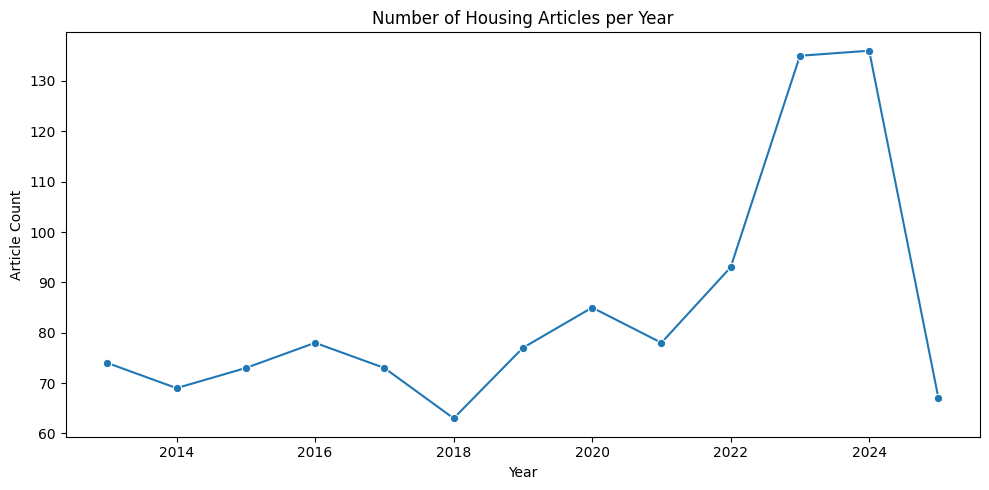

In [20]:
# Articles per year
articles_per_year = df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=articles_per_year.index, y=articles_per_year.values, marker='o')
plt.title("Number of Housing Articles per Year")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.tight_layout()
plt.show()

**Frequency of Articles:** This chart displays the yearly number of housing articles published on DutchNews.nl. After a period of relatively stable coverage from 2013 to 2018, there was a significant increase in articles, indicating a growing focus on the housing crisis. The coverage peaked dramatically in 2023 and 2024, with over 130 articles each year. The lower number for 2025 is because the data only includes articles from the first six months of the year.

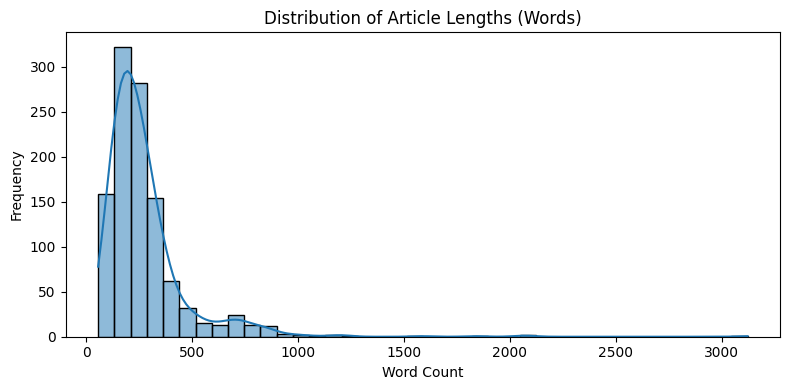

Mean: 276.4568574023615
Median: 224.0


In [22]:
df['word_count'] = df['clean_text'].str.split().str.len()

plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=40, kde=True)
plt.title("Distribution of Article Lengths (Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("Mean:", df['word_count'].mean())
print("Median:", df['word_count'].median())

**Article Lenghts:** This histogram displays the distribution of word counts for the housing articles. The majority of articles are relatively short, with a large cluster appearing between 100 and 400 words. The distribution is right-skewed, indicating that while most articles are concise, there are a few much longer, in-depth pieces. This is further confirmed by the statistics: the median article length is 224 words, while the mean is higher at approximately 276 words, pulled up by the long tail of outlier articles.

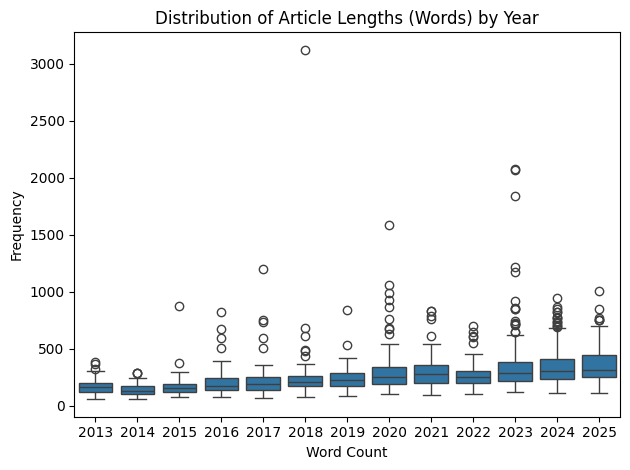

In [24]:
sns.boxplot(data=df, x='year', y='word_count')

plt.title("Distribution of Article Lengths (Words) by Year")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Word Count Distribution Over Years:** This box plot illustrates the distribution of article word counts for each year from 2013 to 2025. The median article length, indicated by the line within each box, remains fairly stable but shows a slight increasing trend in more recent years. The plot also reveals numerous outliers annually, representing articles that are significantly longer than the typical length for that year.

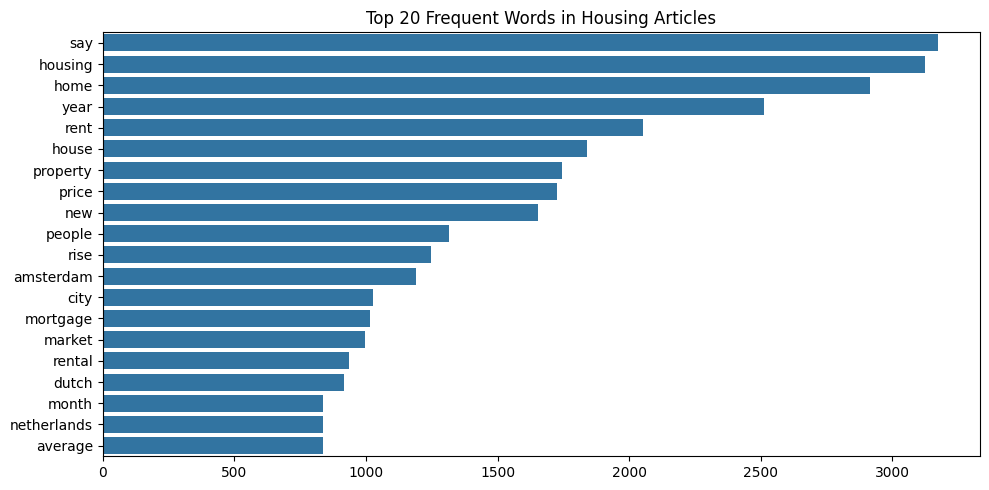

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Top words
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['lemmatized'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

top_words = Counter(word_freq).most_common(20)

# Plot top words
words, freqs = zip(*top_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=freqs, y=words)
plt.title("Top 20 Frequent Words in Housing Articles")
plt.tight_layout()
plt.show()

**Word Frequency:** As expected, core terms like "housing," "home," "house," and "rent" are prominent, confirming the central theme of the dataset. The presence of words like "price," "market," "mortgage," and "rental" points to a strong focus on the financial and economic aspects of housing. Additionally, the inclusion of "Amsterdam," "city," and "Netherlands" highlights the geographical context of the news coverage. While useful for an initial overview, the chart also includes general words like "say" and "year," which, while common, offer less specific insight into the housing narrative itself.

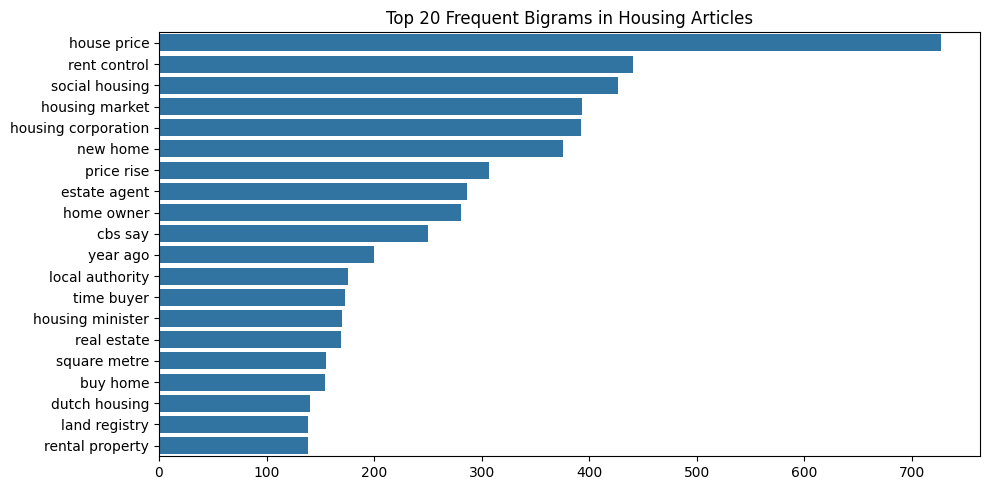

In [28]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=1000)
X2 = bigram_vectorizer.fit_transform(df['lemmatized'])
bigrams = dict(zip(bigram_vectorizer.get_feature_names_out(), X2.sum(axis=0).tolist()[0]))

top_bigrams = Counter(bigrams).most_common(20)

words, freqs = zip(*top_bigrams)
plt.figure(figsize=(10, 5))
sns.barplot(x=freqs, y=words)
plt.title("Top 20 Frequent Bigrams in Housing Articles")
plt.tight_layout()
plt.show()

**Two-word frequency:** The dominance of "house price" and "price rise" clearly points to the affordability crisis as the central theme. Key concepts such as "rent control," "social housing," and the "housing market" are also prominent, indicating a focus on policy and market dynamics. Furthermore, the bigrams identify the main actors involved, including the "housing minister," "estate agents," and "home owners." This analysis reveals the specific contexts in which housing is being discussed.

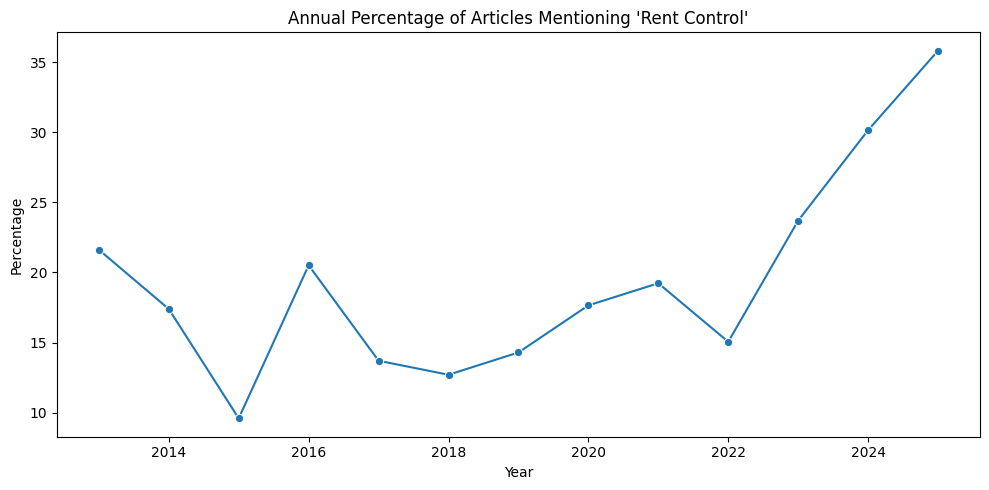

In [30]:
count_rc = df[['year', 'lemmatized']]
count_rc['count'] = count_rc.lemmatized.apply(lambda x: 1 if 'rent control' in x else 0)

ratio_rc = round((count_rc.groupby('year')['count'].sum() / count_rc.groupby('year')['lemmatized'].count()) * 100, 2)

plt.figure(figsize=(10, 5))
sns.lineplot(x=ratio_rc.index, y=ratio_rc.values, marker='o')
plt.title("Annual Percentage of Articles Mentioning 'Rent Control'")
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

**Rent Control:** This chart analyzes the evolving focus of the housing crisis narrative by tracking the percentage of housing articles that mention "rent control" each year. The data reveals a dramatic shift in the conversation: after fluctuating as a secondary topic for nearly a decade, the prominence of "rent control" began a steep and sustained climb starting in 2022. This demonstrates that as the housing crisis intensified, the media and public discourse pivoted sharply, elevating "rent control" from a niche concern to a central, and often dominant, proposed solution.

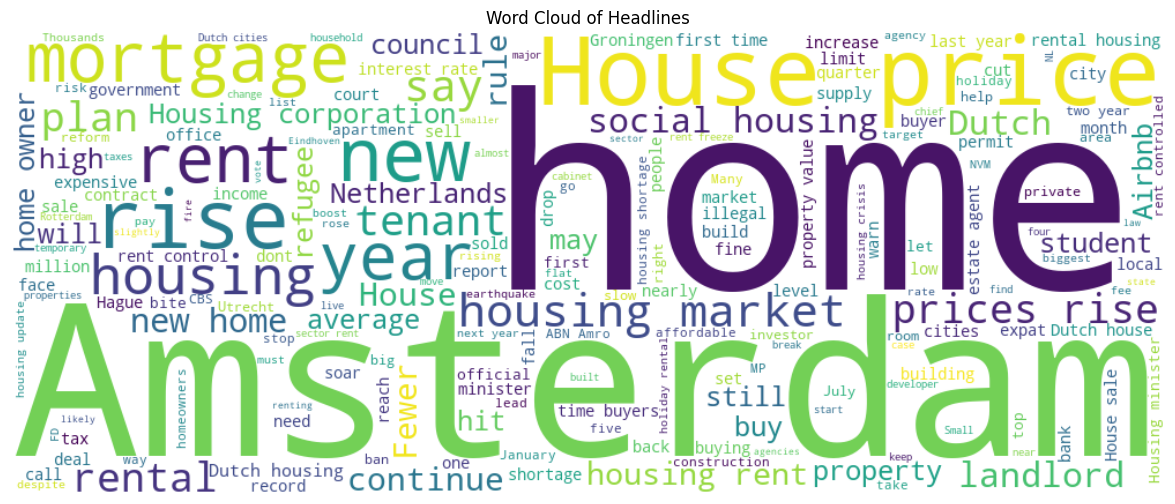

In [32]:
from wordcloud import WordCloud

text = " ".join(df['clean_headline'])
wc = WordCloud(width=1000, height=400, background_color="white").generate(text)

plt.figure(figsize=(15, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud of Headlines")
plt.show()

**Word Cloud of Headlines:** The dominance of "Amsterdam," "home," "housing," "price," and "rent" immediately stands out, establishing the core focus on the housing situation and its cost, with a particular emphasis on Amsterdam. Other significant terms like "market," "mortgage," "rise," "landlord," and "tenant" further underscore the financial and social dynamics at play. The cloud also reveals key issues such as the "housing shortage," the need to "build," and the impact on groups like "students" and "expats," painting a comprehensive picture of a complex and multifaceted crisis.

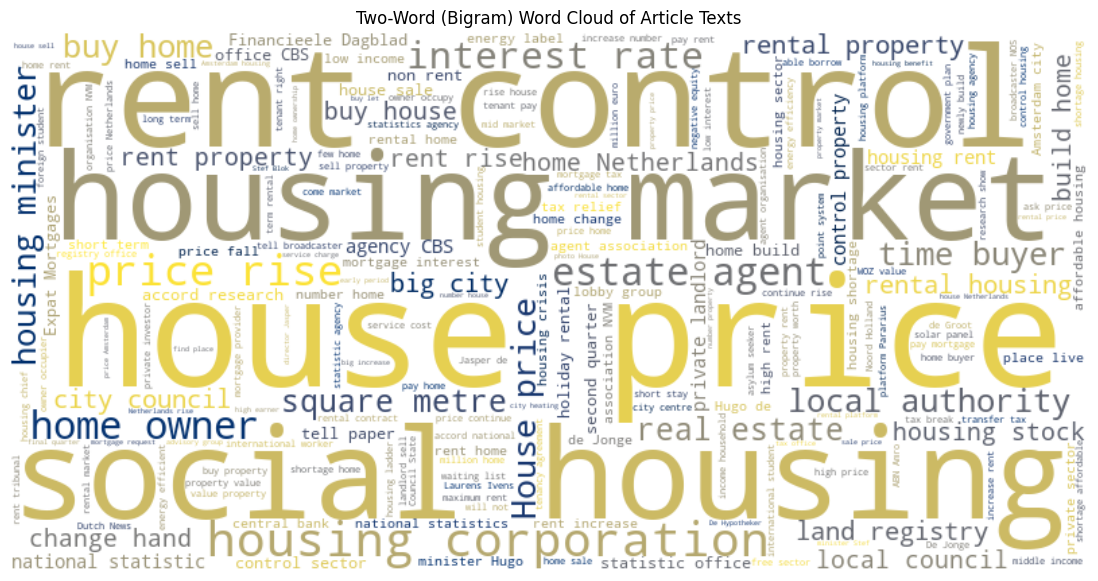

In [34]:
from nltk.util import ngrams

CUSTOM_STOP_WORDS = [
    'say', 'year', 'new', 'people', 'dutch', 'month', 'netherlands', 'average', 'also', 'per', 'pc',
    'cent', 'last', 'first', 'figure', 'according', 'week', 'day', 'january', 'february', 'march',
    'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'cbs', 'ago'
]

all_words = ' '.join(df['lemmatized']).split()
filtered_words = [word for word in all_words if word not in CUSTOM_STOP_WORDS]
bigrams = ngrams(filtered_words, 2)
bigram_freq = Counter(bigrams)
formatted_bigram_freq = {f'{word[0]} {word[1]}': freq for word, freq in bigram_freq.items()}

bigram_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='cividis'
).generate_from_frequencies(formatted_bigram_freq)

plt.figure(figsize=(15, 7))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Two-Word (Bigram) Word Cloud of Article Texts")
plt.show()

**Two-Word Cloud of Article Texts:** This word cloud reveals that the core of the housing discussion revolves around the intersection of policy and economics. Prominent phrases like "social housing," "rent control," and "house price" highlight a narrative focused on government regulation and market affordability. Terms like "home owner," "first-time buyer," and "private landlord" show that the articles discuss the housing issue from multiple perspectives.

### Headline Sentiment Analysis

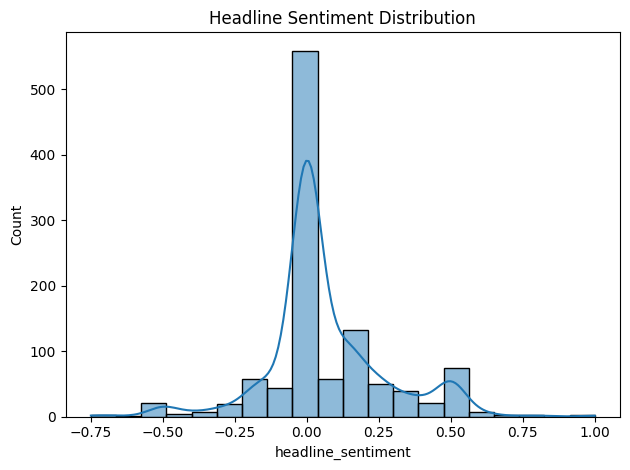

In [37]:
from textblob import TextBlob

df['headline_sentiment'] = df['clean_headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.histplot(df['headline_sentiment'], bins=20, kde=True)
plt.title("Headline Sentiment Distribution")
plt.tight_layout()
plt.show()

**Headline Sentiment:** The most striking feature is the massive peak centered at 0.0, which indicates that the vast majority of headlines are classified as neutral. This is common for news headlines, which are often written in a factual, objective tone. The smaller clusters on both the positive and negative sides show that while some headlines express clear sentiment, they are far less frequent than their neutral counterparts.

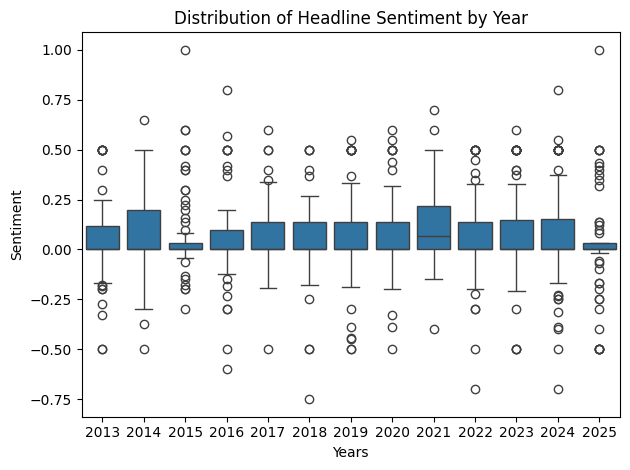

In [39]:
sns.boxplot(data=df, x='year', y='headline_sentiment')

plt.title("Distribution of Headline Sentiment by Year")
plt.xlabel("Years")
plt.ylabel("Sentiment")
plt.tight_layout()
plt.show()

**Headline Sentiment per Year:** The median sentiment, represented by the line inside each box, remains consistently close to 0.0 across all years, reinforcing that the typical headline is neutral. While the bulk of headlines show little emotional language, the numerous outliers (the dots) indicate that every year contains a number of headlines with strong positive or negative sentiment.

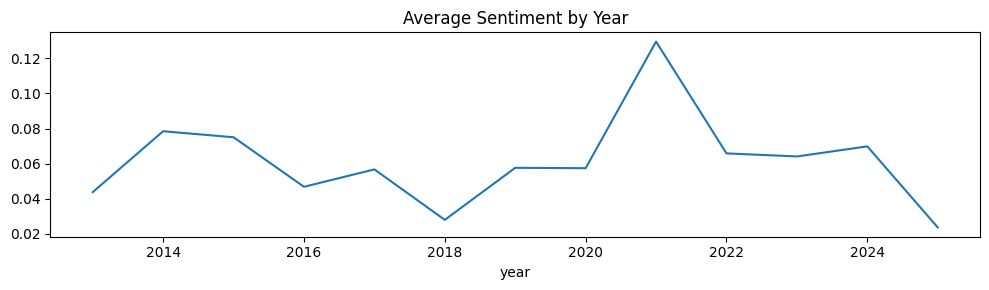

In [41]:
df.groupby('year')['headline_sentiment'].mean().plot(kind='line', 
                                                     figsize=(10,3), title='Average Sentiment by Year')
plt.tight_layout()
plt.show()

**Average Headline Sentiment per Year:** The sentiment score consistently remains slightly positive, indicating that the overall tone of the articles is just above neutral. While there are fluctuations from year to year, with a notable peak in positive sentiment in 2021 and a dip in 2018, there is no sustained long-term trend toward a more positive or negative narrative.

### Topic Modeling & Trend Analysis

In [44]:
from bertopic import BERTopic

texts = df['lemmatized'].tolist()

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(texts)

df['topic_id'] = topics
df['topic_name'] = df['topic_id'].apply(lambda x: topic_model.get_topic(x)[0][0] if x != -1 else "Other")

2025-07-28 11:50:29.575037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-28 11:50:39,834 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

2025-07-28 11:51:42,394 - BERTopic - Embedding - Completed ✓
2025-07-28 11:51:42,395 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-28 11:51:51,774 - BERTopic - Dimensionality - Completed ✓
2025-07-28 11:51:51,774 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-28 11:51:51,878 - BERTopic - Cluster - Completed ✓
2025-07-28 11:51:51,881 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-28 11:51:52,024 - BERTopic - Representation - Completed ✓


In [45]:
topic_model.visualize_barchart(top_n_topics=10)

topics_over_time = topic_model.topics_over_time(texts, df['year'])
topic_model.visualize_topics_over_time(topics_over_time)

13it [00:00, 22.27it/s]


#### Key Insights From Topics Over Time:

**1. The Dominant Narrative: House Prices and the Market**

*   For most of the last decade, the foundational topic has been **House Prices & Market**. This topic, focused on the general economy of housing, was the most frequently discussed for years.
*   Its prominence peaked dramatically around **2015** and again in **2022**, likely corresponding to periods of intense market volatility and public concern over affordability. While still a major topic, its dominance has been challenged in recent years by more specific issues.

**2. The Recent Surge in Policy and Regulation**

*   A major shift in the narrative is visible after 2022, with a clear pivot towards policy and regulation. This is most evident in the topics related to renting and mortgages.
*   **Topics related to rent, tenants, and landlords (e.g., Topic 5 and Topic 10)** saw a dramatic spike in coverage starting in 2022. This trend aligns perfectly with the political debate and introduction of the **Affordable Rent Act**, which came into effect in 2024.
*   Similarly, **Topic 3: Mortgages & Home Buying** surged in prominence after 2022, suggesting the conversation moved from just the cost of housing to the practical challenges and financial instruments involved in purchasing a home.

**3. The Influence of Social and Global Events**

The data clearly shows how external events shape the housing news agenda:

*   **Topic 8: Airbnb & Holiday Rentals (light blue line)** shows a distinct peak in **2020**. This strongly suggests that the COVID-19 pandemic and its impact on tourism and the short-stay rental market became a major, albeit temporary, focus of the housing discussion.
*   **Topic 9: Refugee Accommodation (dark green line)** has seen a steady and significant rise since 2019, peaking in 2023-2024. This trend reflects the increasing political and social importance of finding housing solutions for asylum seekers, an issue that became central with recent shifts in government policy.

**Conclusion:**

The analysis demonstrates that the Dutch housing narrative is not monolithic. It began the decade largely focused on broad market economics but has since evolved into a more complex and multifaceted conversation. In recent years, the focus has clearly shifted to **specific government interventions** (like rent control) and **pressing social responsibilities** (such as housing for refugees and students), indicating that the housing crisis is now being framed as an urgent political and social challenge, not just an economic one.

In [47]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

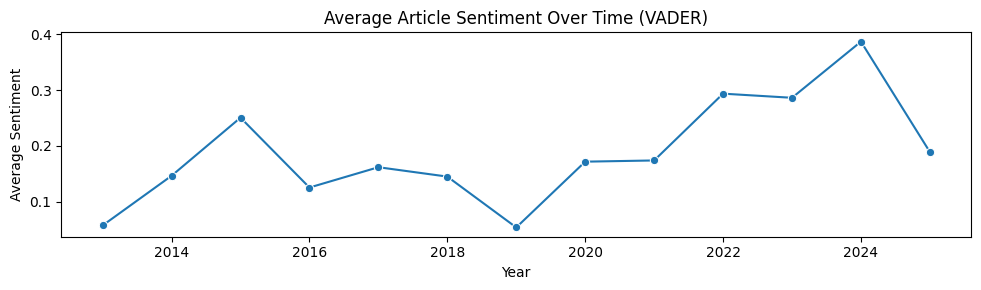

In [48]:
yearly_sentiment = df.groupby('year')['vader_sentiment'].mean()

plt.figure(figsize=(10, 3))

sns.lineplot(data=yearly_sentiment, marker='o')
plt.title("Average Article Sentiment Over Time (VADER)")
plt.xlabel("Year")
plt.ylabel("Average Sentiment")
plt.tight_layout()
plt.show()

**Article Sentiment Over Time:** The analysis shows that the overall sentiment is consistently positive, with scores remaining well above zero. There is a clear upward trend in positivity from 2019 onwards, reaching a decade-high peak in 2024. This suggests that while the articles discuss the problems of the housing crisis, the language used—perhaps focusing on proposed solutions, government plans, and positive actions—has become increasingly positive in recent years.

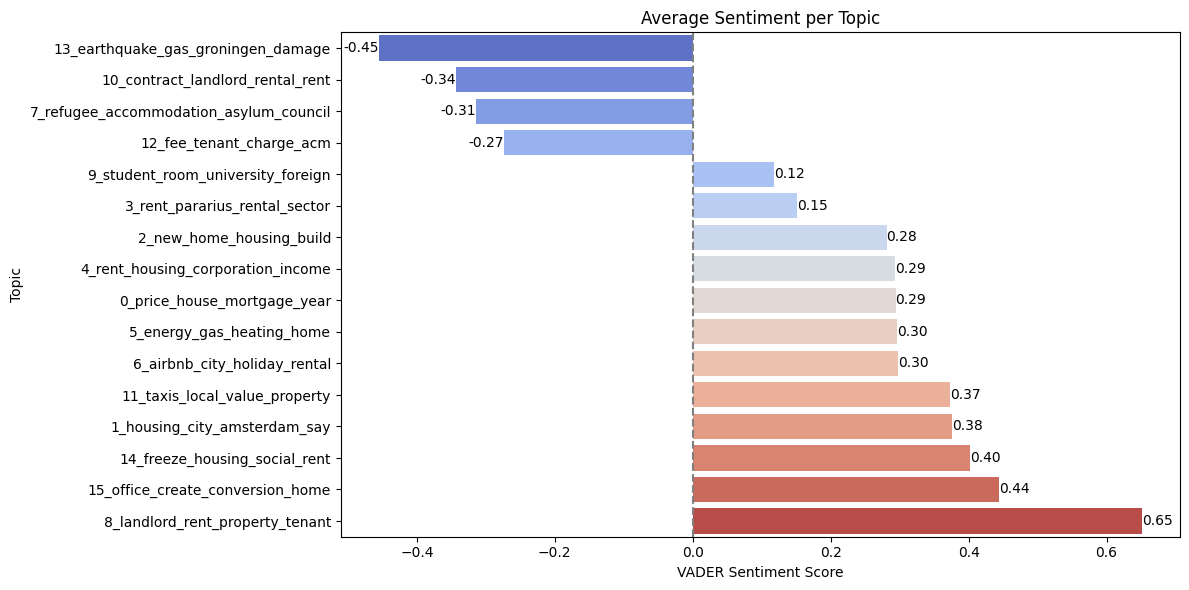

In [50]:
topic_sentiment = df[df['topic_id'] != -1].groupby('topic_id')['vader_sentiment'].mean().reset_index()

topic_sentiment['topic_name'] = topic_sentiment['topic_id'].apply(lambda x: topic_model.get_topic_info().set_index('Topic').loc[x]['Name'])

topic_sentiment_sorted = topic_sentiment.sort_values('vader_sentiment')

plt.figure(figsize=(12, 6))
ax = sns.barplot(y='topic_name', x='vader_sentiment', data=topic_sentiment_sorted, palette='coolwarm')
plt.axvline(0, linestyle='--', color='gray')
plt.title("Average Sentiment per Topic")

for container in ax.containers:
    plt.bar_label(container, fmt='%.2f')

plt.xlabel("VADER Sentiment Score")
plt.ylabel("Topic")

plt.tight_layout()
plt.show()

### Average Sentiment per Topic

This chart reveals a clear division in how different housing topics are framed.

*   **Negative Topics:** The most negatively-toned discussions focus on concrete problems and damages, such as **foundation/climate risks** (-0.72) and the **Groningen earthquakes** (-0.45). Topics like landlord disputes and refugee accommodation also carry a negative sentiment, reflecting social friction.

*   **Positive Topics:** In contrast, the most positive language is used for topics framed as solutions or financial opportunities. **Mortgages and home buying** (+0.81) is by far the most positive, followed by discussions on **rent control** (+0.62) and converting offices to homes, which are presented as proactive measures.

It is important to consider the primary audience of DutchNews.nl are expats seeking practical information about the housing market. This likely explains the pragmatic tone found in the analysis, where headlines are generally neutral and factual, while articles about home buying and mortgages are framed more positively as opportunities.

In [52]:
# Most positive headlines

pd.set_option('display.max_colwidth', None)

df[df['topic_id'] == 3].sample(10)[['headline']]

headline
270        Tenants overbidding by up to €300 a month for scarce city homes
35            House prices dip in big cities as landlords sell off rentals
855                      Private sector rents skyrocket in the Netherlands
1004     Fewer private sector homes for rent, €700 plus in greatest demand
917   Sharp rise in housing rents, Amsterdam has never been more expensive
947                                 Private sector rents soar in Amsterdam
558     Eindhoven draws up rules for flat sharing, brings in 30 metre rule
106         Rents went up 5.4% in July – the highest rise in over 30 years
73            An affordable home in Amsterdam attracts 450 hopeful tenants
358    Rents soar in big Dutch cities as government squeezes ‘free’ sector

In [53]:
# Refugee Housing headlines

df[df['topic_id'] == 10].sample(10)[['headline']]

headline
125                          Here’s what changes in the Netherlands from July 1
43               Fake “short-term” student rental cut from €1,500 to under €300
61             Short stay, expats only: landlords try to get round rental rules
233                No criminals need apply for large house next to Dutch prison
509  Expat home hunters hit by scams, complicated rules and income requirements
763                        Amsterdam housing agency says ‘western cooking only’
2                Amsterdam landlords continue to charge illegal rents for rooms
59                 Rentbusters: Amsterdam launches city team on landlord abuses
672    Conman ‘estate agent’ steals thousands of euros from expats in Amsterdam
762          Apartment owner denies ‘western cooking only’ was part of the deal

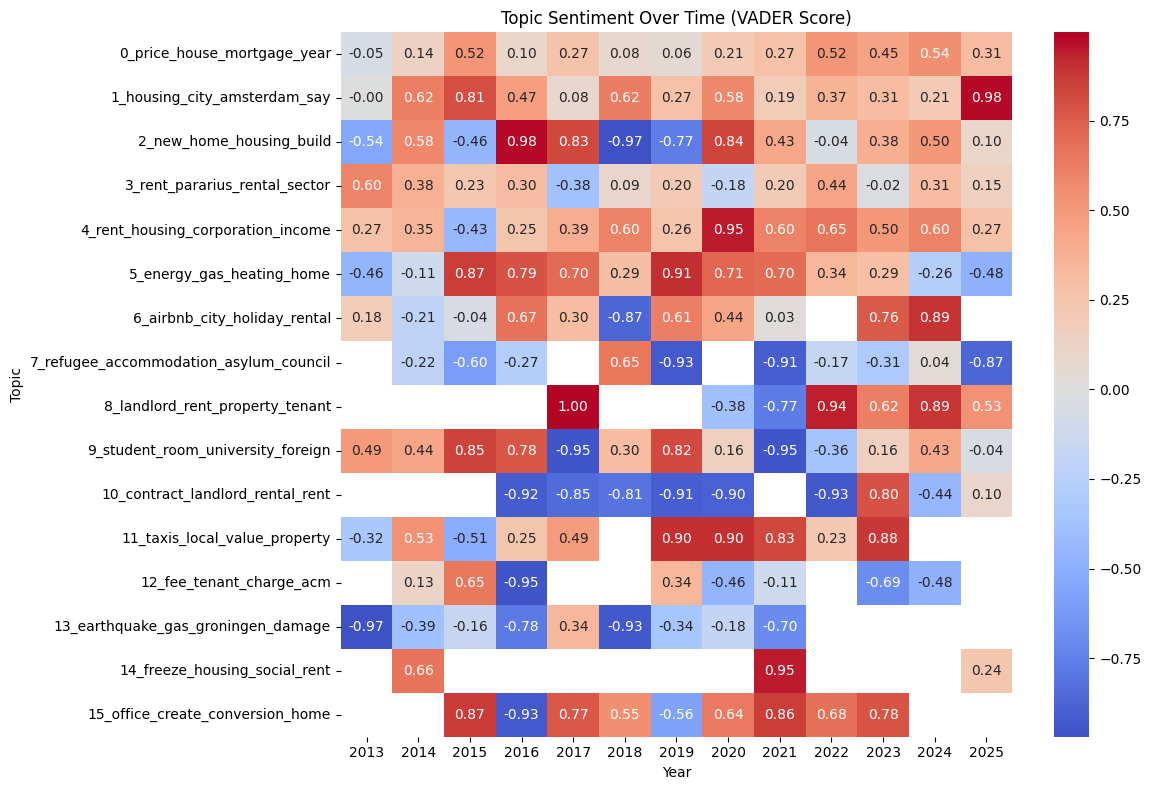

In [54]:
matrix = df[df['topic_id'] != -1].groupby(['topic_id', 'year'])['vader_sentiment'].mean().unstack()
matrix.index = matrix.index.map(lambda x: topic_model.get_topic_info().set_index('Topic').loc[x]['Name'])

plt.figure(figsize=(12, 8))
sns.heatmap(matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Topic Sentiment Over Time (VADER Score)")
plt.ylabel("Topic")
plt.xlabel("Year")
plt.tight_layout()

plt.savefig('Topic Sentiment Over Time.png')

plt.show()

### Topic Sentiment Heatmap Analysis

This heatmap provides a powerful, year-by-year visualization of how the sentiment for each topic has evolved. It combines the "what" (the topic) with the "how" (the sentiment), revealing a dynamic and evolving narrative.

*   **Persistently Framed Topics:** Some topics maintain a consistent emotional tone over the years.
    *   **Consistently Positive (Red):** `Topic 3 (Mortgages & Home Buying)` and `Topic 10 (Rent Control)` are framed almost universally as positive, suggesting they are discussed as solutions or opportunities.
    *   **Consistently Negative (Blue):** `Topic 13 (Groningen Earthquakes)` and `Topic 16 (Foundation & Climate Risks)` remain persistently negative, reflecting their status as ongoing problems with damaging consequences.

*   **Evolving Narratives:** Other key topics show significant shifts in sentiment, highlighting changes in the public discourse.
    *   **`Topic 2 (New Home Construction)`** starts positive, turns sharply negative around 2019, and then recovers. This likely mirrors the real-world narrative shifting from "building is the solution" to confronting challenges like the nitrogen crisis, before returning to a focus on positive action.
    *   The sentiment around **`Topic 8 (Airbnb)`** and **`Topic 9 (Refugee Accommodation)`** is highly volatile, with sharp swings between positive and negative sentiment from one year to the next. This underscores the contentious and politically charged nature of these specific debates.

**Conclusion:**

This granular view demonstrates that the housing narrative is not static. The heatmap successfully visualizes which issues have a fixed positive or negative framing and, more importantly, which issues are at the heart of an evolving public debate where the tone and focus change dramatically over time.